In [2]:
import rvm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [53]:
__author__ = 'andrew'
import numpy as np


class RVMRegression:
    """RVM Regression class"""
    fitted = False
    alpha = None
    betta = None
    kernel = 'linear'
    data_x = None
    data_t = None
    alpha_bound = 10**12
    weight_bound = 10**-6
    number_of_iterations = 100
    F = None
    kernel_m = None
    D = 0
    w = None
    inv_a = None

    def __init__(self, alpha=None, betta=None, kernel='linear', coef0=0, gamma=1, degree=2, number_of_iterations=100):
        if alpha:
            self.alpha = alpha

        if betta:
            self.betta = betta

        self.coef0 = coef0
        self.degree = degree
        self.gamma = gamma
        self.kernel = kernel
        self.number_of_iterations = number_of_iterations

    def fit(self, x, t):
        if len(x) == 0:
            raise NameError("X array is empty!")
        if len(x) != len(t):
            raise NameError("Different len X and t")

        self.D = len(x[0])

        if self.kernel in ['linear']:
            self.kernel_m = len(x[0])

        if self.kernel in ['rbf', 'poly']:
            self.kernel_m = len(x) + 1

        self.data_x = x.copy()
        self.data_t = t.copy()

        if not self.alpha:
            self.alpha = np.array([1.] * self.kernel_m)

        if not self.betta:
            self.betta = 1

        self.create_f()
        gamma = np.array([0] * self.kernel_m)
        w_mp = None
        t_matrix = np.matrix(self.data_t)

        for k in range(self.number_of_iterations):
            sigma = np.linalg.pinv(self.betta * (self.F.T * self.F) + np.matrix(np.diag(self.alpha)))
            w_mp = sigma * self.F.T * (self.betta * t_matrix)
            for j in range(self.kernel_m):
                if np.abs(w_mp.A[j]) < self.weight_bound or np.abs(self.alpha[j]) > self.alpha_bound:
                    w_mp.A[j] = 0
                    self.alpha[j] = 10**10
                    gamma[j] = 0
                else:
                    gamma[j] = 1 - self.alpha[j] * sigma.A[j][j]
                    self.alpha[j] = gamma[j] / (w_mp.A[j][0] ** 2)

            if (np.linalg.norm(t_matrix - self.F * w_mp) ** 2) == 0:
                self.betta = 10**10
                break
            else:
                self.betta = (self.D - sum(gamma)) / (np.linalg.norm(t_matrix - self.F * np.matrix(w_mp)) ** 2)

        self.w = w_mp

    def create_f(self):
        self.F = []
        for i in range(len(self.data_t)):
            self.F.append([self.phi(self.data_x[i], j) for j in range(self.kernel_m)])
        self.F = np.matrix(self.F)

    def calc_sigma(self):
        a = np.matrix(np.diag(self.alpha))
        try:
            inv_a = np.linalg.inv(a)
        except np.linalg.LinAlgError:
            inv_a = np.linalg.pinv(a)

        self.inv_a = inv_a.copy()
        print(self.inv_a)
        e = np.matrix(np.diag([1] * a.shape[0]))
        tmp_mat = np.linalg.pinv(e + self.betta * self.F * self.inv_a * self.F.T)
        return self.inv_a - self.inv_a * self.betta * self.F.T * tmp_mat * self.F * self.inv_a

    def get_m(self):
        return self.kernel_m
        if self.kernel in ['linear', 'poly']:
            return len(self.data_x[0])

    def phi(self, x, i):
        if self.kernel == 'linear':
            return x[i]
        if self.kernel == 'poly':
            if i == self.kernel_m - 1:
                return 1
            res = self.coef0
            for j in range(len(x)):
                res += x[j] * self.data_x[i][j]
            return res ** self.degree
        if self.kernel == 'rbf':
            if i == self.kernel_m - 1:
                return 1
            return np.exp((-1.) * self.gamma * (np.linalg.norm(x - self.data_x[i]) ** 2))

    def predict(self, data_x):
        if self.w is None:
            raise NameError("Classifier don't fitted yet!")
        t_ans = []
        for x in data_x:
            t = 0
            for j in range(self.kernel_m):
                t += self.w.A[j] * self.phi(x, j)
            t_ans.append(t)
        return np.array(t_ans)

    def validity(self):
        e = np.matrix(np.diag([1 / self.betta] * self.kernel_m))
        tmp = np.exp(-0.5 * (self.data_t.T * np.linalg.pinv(e + self.F * self.inv_a * self.F.T) * self.data_t))
        return  tmp

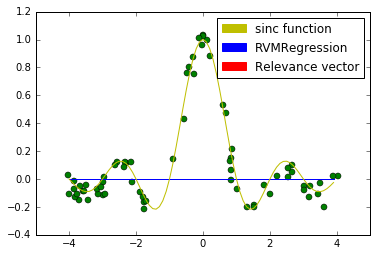

In [54]:
cl = RVMRegression(kernel='rbf', number_of_iterations=100, gamma=0.5)

data_x = np.random.uniform(-4, 4, 70)
noise = np.random.normal(0, 0.1, len(data_x))

data_y = np.sinc(data_x)

data_x = np.sum([data_x, noise], axis=0)
noise = np.random.normal(0, 0.05, len(data_x))
data_y = np.sum([data_y, noise], axis=0)

data_x = np.array([[x] for x in data_x])
data_y = np.array([[y] for y in data_y])

cl.fit(data_x, data_y)

valid_x = np.arange(-4, 4, 0.1)
valid_x = [[el] for el in valid_x]
valid_y = cl.predict(valid_x)


relevance_vectors = {'x':[], 'y':[]}
for i in range(len(cl.w) - 1):
    if cl.w[i] != 0:
        relevance_vectors['x'].append(data_x[i])
        relevance_vectors['y'].append(data_y[i])

plt.plot(data_x, data_y, 'go')
plt.plot(relevance_vectors['x'], relevance_vectors['y'], 'ro')
plt.plot(valid_x, valid_y)

x = np.arange(-4, 4, 0.1)
y = np.sinc(x)
plt.plot(x, y, "y")


sinc = mpatches.Patch(color='y', label='sinc function')
rvm_regression = mpatches.Patch(color='b', label='RVMRegression')
relevance = mpatches.Patch(color='r', label='Relevance vector')

plt.legend(handles=[sinc, rvm_regression, relevance])

plt.show()

In [55]:
cl.validity()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [57]:
print(cl.inv_a)

None
